## Sampling from the new Datacube

In [1]:
# Import required libraries
import xarray as xr
from pathlib import Path
import numpy as np
import datetime
import pandas as pd
import cfgrib
import os
import shutil
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
final_cube = xr.open_dataset(Path.home() / 'hdd1/diogenis/observatory/dwd_meteo.nc')

In [3]:
final_cube

<xarray.Dataset>
Dimensions:         (time: 172, y: 983, x: 1253)
Coordinates:
  * time            (time) datetime64[ns] 2021-07-13T12:00:00 ... 2021-12-31T...
  * x               (x) float64 18.7 18.71 18.72 18.73 ... 28.88 28.89 28.9
  * y               (y) float64 42.3 42.29 42.28 42.27 ... 34.32 34.31 34.3
Data variables: (12/15)
    max_t2m         (time, y, x) float32 ...
    min_t2m         (time, y, x) float32 ...
    avg_t2m         (time, y, x) float32 ...
    max_tp          (time, y, x) float32 ...
    min_tp          (time, y, x) float32 ...
    avg_tp          (time, y, x) float32 ...
    ...              ...
    max_v10         (time, y, x) float32 ...
    min_v10         (time, y, x) float32 ...
    avg_v10         (time, y, x) float32 ...
    max_wind_speed  (time, y, x) float32 ...
    min_wind_speed  (time, y, x) float32 ...
    avg_wind_speed  (time, y, x) float32 ...

In [4]:
def copy_files(path, label, src):
    if src == 'dwd':
        if label == 'positives':
            destination_folder = Path.home() / 'hdd1/diogenis/observatory/positives'
        else:
            destination_folder = Path.home() / 'hdd1/diogenis/observatory/negatives'
    else:
        if label == 'positives':
            destination_folder = Path.home() / 'hdd1/diogenis/observatory/positives_era5'
        else:
            destination_folder = Path.home() / 'hdd1/diogenis/observatory/negatives_era5'
        
    #For Every file
    for file_name in os.listdir(path):
        #Get the date from the file name
        file_date = file_name.split('_')[0][:4] + '/' + file_name.split('_')[0][4:6] + '/' + file_name.split('_')[0][6:]
        
        #Convert from string to datetime
        file_date = datetime.strptime(file_date, '%Y/%m/%d')
        
        #If the year is 2021
        if file_date.year == 2021:
            
            #Check for the month and the day(We start from 23 couse we want to have to 10 past days)
            if (file_date.month ==7 and file_date.day >=22) or (file_date.month >=8 and file_date.month <= 12):
                
                #We don't care about the mode.npy files
                if file_name.split('_')[3] == 'static.npy' or file_name.split('_')[3] == 'dynamic.npy' or file_name.split('_')[4] == 'vec.npy':
                    source = path / file_name
                    destination = destination_folder / file_name
                    if os.path.isfile(source):
                        shutil.copy(source, destination)

In [5]:
path = Path.home() / 'hdd1/iprapas/uc3/datasets_v4/npy/temporal/positives'
copy_files(path, 'positives','dwd')

In [6]:
copy_files(path, 'positives', 'era5')

In [7]:
path = Path.home() / 'hdd1/iprapas/uc3/datasets_v5/npy/temporal/negatives_clc'
copy_files(path, 'negatives', 'dwd')

In [8]:
copy_files(path, 'negatives', 'era5')

In [9]:
values_t2m_era5 = []
values_wind_speed_era5 = []
values_tp_era5 = []
values_t2m_positives_era5 = []
values_wind_speed_positives_era5 = []
values_tp_positives_era5 = []
values_t2m_negatives_era5 = []
values_wind_speed_negatives_era5 = []
values_tp_negatives_era5 = []
    
values_t2m_dwd = []
values_wind_speed_dwd = []
values_tp_dwd = []
values_t2m_positives_dwd = []
values_wind_speed_positives_dwd = []
values_tp_positives_dwd = []
values_t2m_negatives_dwd = []
values_wind_speed_negatives_dwd = []
values_tp_negatives_dwd = []

In [10]:
def change_npy_files(path):
    #For every file
    for file_name in os.listdir(path):
        
        #Only if the file is dynamic.npy
        if file_name.split('_')[3] == 'dynamic.npy':
            
            #Get the date
            file_date = file_name.split('_')[0][:4] + '/' + file_name.split('_')[0][4:6] + '/' + file_name.split('_')[0][6:]
            file_date = datetime.strptime(file_date, '%Y/%m/%d')
            file_date = np.datetime64(file_date)
            
            #Add 12 hours so it matches the dimension in our datacube
            file_date = file_date + np.timedelta64(12, 'h')
            
            #Get the lat and lon
            x_index = file_name.split('_')[1]
            x_index = int(x_index)
            y_index = file_name.split('_')[2]
            y_index = int(y_index)

            #Open the file
            test = np.load(path / file_name)
            values_t2m_era5.append(test[9][10])
            values_wind_speed_era5.append(test[9][30])
            values_tp_era5.append(test[9][12])
            if path.parts[-1] == 'positives':
                values_t2m_positives_era5.append(test[9][10])
                values_wind_speed_positives_era5.append(test[9][30])
                values_tp_positives_era5.append(test[9][12])
            else:
                values_t2m_negatives_era5.append(test[9][10])
                values_wind_speed_negatives_era5.append(test[9][30])
                values_tp_negatives_era5.append(test[9][12])
            
            #For every day in the file
            for i in range(10):
                
                #Get the appropriate date
                tmp = file_date - np.timedelta64(9-i,'D')
                
                #Get the values from the datacube
                dwd_max_u10 = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).max_u10.values
                dwd_max_v10 = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).max_v10.values
                dwd_max_t2m = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).max_t2m.values
                dwd_max_tp = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).max_tp.values
            
                dwd_min_u10 = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).min_u10.values
                dwd_min_v10 = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).min_v10.values
                dwd_min_t2m = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).min_t2m.values
                dwd_min_tp = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).min_tp.values
            
                dwd_avg_u10 = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).avg_u10.values
                dwd_avg_v10 = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).avg_v10.values
                dwd_avg_t2m = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).avg_t2m.values
                dwd_avg_tp = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).avg_tp.values
            
                dwd_max_wind_speed = final_cube.sel(time = tmp).isel(x = x_index, y = y_index).max_wind_speed.values
                
                if i == 9:
                    values_t2m_dwd.append(dwd_max_t2m)
                    values_wind_speed_dwd.append(dwd_max_wind_speed)
                    values_tp_dwd.append(dwd_max_tp)
                    if path.parts[-1] == 'positives':
                        values_t2m_positives_dwd.append(dwd_max_t2m)
                        values_wind_speed_positives_dwd.append(dwd_max_wind_speed)
                        values_tp_positives_dwd.append(dwd_max_tp)
                    else:
                        values_t2m_negatives_dwd.append(dwd_max_t2m)
                        values_wind_speed_negatives_dwd.append(dwd_max_wind_speed)
                        values_tp_negatives_dwd.append(dwd_max_tp)
            
                #Change the values in the file
                test[i][7] = dwd_max_u10
                test[i][8] = dwd_max_v10
                test[i][10] = dwd_max_t2m
                test[i][12] = dwd_max_tp
                test[i][13] = dwd_min_u10
                test[i][14] = dwd_min_v10
                test[i][16] = dwd_min_t2m
                test[i][18] = dwd_min_tp
                test[i][19] = dwd_avg_u10
                test[i][20] = dwd_avg_v10
                test[i][22] = dwd_avg_t2m
                test[i][24] = dwd_avg_tp
                test[i][30] = dwd_max_wind_speed
            
            #Save the new values to the file
            np.save(path / file_name, test)

In [11]:
path = Path.home() / 'hdd1/diogenis/observatory/positives'
change_npy_files(path)

In [12]:
path = Path.home() / 'hdd1/diogenis/observatory/negatives'
change_npy_files(path)

In [13]:
values_t2m_era5 = np.array(values_t2m_era5)
values_wind_speed_era5 = np.array(values_wind_speed_era5)
values_tp_era5 = np.array(values_tp_era5)
values_t2m_positives_era5 = np.array(values_t2m_positives_era5)
values_wind_speed_positives_era5 = np.array(values_wind_speed_positives_era5)
values_tp_positives_era5 = np.array(values_tp_positives_era5)
values_t2m_negatives_era5 = np.array(values_t2m_negatives_era5)
values_wind_speed_negatives_era5 = np.array(values_wind_speed_negatives_era5)
values_tp_negatives_era5 = np.array(values_tp_negatives_era5)

values_t2m_dwd = np.array(values_t2m_dwd)
values_wind_speed_dwd = np.array(values_wind_speed_dwd)
values_tp_dwd = np.array(values_tp_dwd)
values_t2m_positives_dwd = np.array(values_t2m_positives_dwd)
values_wind_speed_positives_dwd = np.array(values_wind_speed_positives_dwd)
values_tp_positives_dwd = np.array(values_tp_positives_dwd)
values_t2m_negatives_dwd = np.array(values_t2m_negatives_dwd)
values_wind_speed_negatives_dwd = np.array(values_wind_speed_negatives_dwd)
values_tp_negatives_dwd = np.array(values_tp_negatives_dwd)

In [14]:
t2m_difference = values_t2m_era5 - values_t2m_dwd
wind_speed_difference = values_wind_speed_era5 - values_wind_speed_dwd
tp_difference = values_tp_era5 - values_tp_dwd
t2m_positives_difference = values_t2m_positives_era5 - values_t2m_positives_dwd
tp_positives_difference = values_tp_positives_era5 - values_tp_positives_dwd
wind_speed_positives_difference = values_wind_speed_positives_era5 - values_wind_speed_positives_dwd
t2m_negatives_difference = values_t2m_negatives_era5 - values_t2m_negatives_dwd
tp_negatives_difference = values_tp_negatives_era5 - values_tp_negatives_dwd
wind_speed_negatives_difference = values_wind_speed_negatives_era5 - values_wind_speed_negatives_dwd

In [15]:
def compare_stats(era5, dwd, stat):
    era5_max = era5.max()
    dwd_max = dwd.max()
    print('The era5 max ' + stat + ' is: ' + str(era5_max))
    print('The dwd max ' + stat + ' is: ' + str(dwd_max))
    
    era5_min = era5.min()
    dwd_min = dwd.min()
    print('The era5 min ' + stat + ' is: ' + str(era5_min))
    print('The dwd min ' + stat + ' is: ' + str(dwd_min))
    
    era5_avg = era5.mean()
    dwd_avg = dwd.mean()
    print('The era5 avg ' + stat + ' is: ' + str(era5_avg))
    print('The dwd avg ' + stat + ' is: ' + str(dwd_avg))
    
    era5_std = era5.std()
    dwd_std = dwd.std()
    print('The era5 std ' + stat + ' is: ' + str(era5_std))
    print('The dwd std ' + stat + ' is: ' + str(dwd_std))

In [16]:
compare_stats(values_t2m_era5, values_t2m_dwd, 't2m')

The era5 max t2m is: 314.914
The dwd max t2m is: 317.35217
The era5 min t2m is: 290.84912
The dwd min t2m is: 288.9895
The era5 avg t2m is: 307.9903
The dwd avg t2m is: 309.40182
The era5 std t2m is: 4.270157
The dwd std t2m is: 5.2756066


In [17]:
compare_stats(values_wind_speed_era5, values_wind_speed_dwd, 'wind speed')

The era5 max wind speed is: 12.721206
The dwd max wind speed is: 11.271001
The era5 min wind speed is: 0.74049556
The dwd min wind speed is: 0.97629046
The era5 avg wind speed is: 4.284084
The dwd avg wind speed is: 5.0259604
The era5 std wind speed is: 1.7937676
The dwd std wind speed is: 1.9416236


In [18]:
compare_stats(values_tp_era5, values_tp_dwd, 'tp')

The era5 max tp is: 0.04634493
The dwd max tp is: 0.024033204
The era5 min tp is: 0.0
The dwd min tp is: 0.0
The era5 avg tp is: 0.00032398105
The dwd avg tp is: 0.00015855567
The era5 std tp is: 0.002099894
The dwd std tp is: 0.0012301025


In [19]:
compare_stats(values_t2m_positives_era5, values_t2m_positives_dwd, 't2m positives')

The era5 max t2m positives is: 314.914
The dwd max t2m positives is: 317.35217
The era5 min t2m positives is: 295.7981
The dwd min t2m positives is: 298.5094
The era5 avg t2m positives is: 308.97565
The dwd avg t2m positives is: 310.547
The era5 std t2m positives is: 3.3970466
The dwd std t2m positives is: 4.39506


In [20]:
compare_stats(values_wind_speed_positives_era5, values_wind_speed_positives_dwd, 'wind speed positives')

The era5 max wind speed positives is: 12.721206
The dwd max wind speed positives is: 11.271001
The era5 min wind speed positives is: 1.2105005
The dwd min wind speed positives is: 1.792283
The era5 avg wind speed positives is: 4.450624
The dwd avg wind speed positives is: 5.1308603
The era5 std wind speed positives is: 1.7233194
The dwd std wind speed positives is: 1.9570065


In [21]:
compare_stats(values_tp_positives_era5, values_tp_positives_dwd, 'tp positives')

The era5 max tp positives is: 0.003579609
The dwd max tp positives is: 0.008996094
The era5 min tp positives is: 0.0
The dwd min tp positives is: 0.0
The era5 avg tp positives is: 3.321654e-05
The dwd avg tp positives is: 1.3147829e-05
The era5 std tp positives is: 0.00012738511
The dwd std tp positives is: 0.00021703528


In [22]:
compare_stats(values_t2m_negatives_era5, values_t2m_negatives_dwd, 't2m negatives')

The era5 max t2m negatives is: 312.05972
The dwd max t2m negatives is: 311.75113
The era5 min t2m negatives is: 290.84912
The dwd min t2m negatives is: 288.9895
The era5 avg t2m negatives is: 301.53278
The dwd avg t2m negatives is: 301.8974
The era5 std t2m negatives is: 3.7472901
The dwd std t2m negatives is: 4.3273787


In [23]:
compare_stats(values_wind_speed_negatives_era5, values_wind_speed_negatives_dwd, 'wind speed negatives')

The era5 max wind speed negatives is: 11.126452
The dwd max wind speed negatives is: 10.93111
The era5 min wind speed negatives is: 0.74049556
The dwd min wind speed negatives is: 0.97629046
The era5 avg wind speed negatives is: 3.1926913
The dwd avg wind speed negatives is: 4.338512
The era5 std wind speed negatives is: 1.8623742
The dwd std wind speed negatives is: 1.6829104


In [24]:
compare_stats(values_tp_negatives_era5, values_tp_negatives_dwd, 'tp negatives')

The era5 max tp negatives is: 0.04634493
The dwd max tp negatives is: 0.024033204
The era5 min tp negatives is: 0.0
The dwd min tp negatives is: 0.0
The era5 avg tp negatives is: 0.002229458
The dwd avg tp negatives is: 0.0011114617
The era5 std tp negatives is: 0.0053866142
The dwd std tp negatives is: 0.0031739664


In [25]:
def calculate_difference_stats(arr, stat):
    print("The max of " + stat + ' difference is ' + str(arr.max()))
    print("The min of " + stat + ' difference is ' + str(arr.min()))
    print("The avg of " + stat + ' difference is ' + str(arr.mean()))
    print("The std of " + stat + ' difference is ' + str(arr.std()))

In [26]:
calculate_difference_stats(t2m_difference, 't2m')

The max of t2m difference is 7.4163513
The min of t2m difference is -11.46756
The avg of t2m difference is -1.4115715
The std of t2m difference is 2.869561


In [27]:
calculate_difference_stats(wind_speed_difference, 'wind speed')

The max of wind speed difference is 8.840739
The min of wind speed difference is -5.775268
The avg of wind speed difference is -0.74187624
The std of wind speed difference is 2.1902664


In [28]:
calculate_difference_stats(tp_difference, 'tp')

The max of tp difference is 0.03002071
The min of tp difference is -0.015572326
The avg of tp difference is 0.00016542539
The std of tp difference is 0.0014382062


In [29]:
calculate_difference_stats(t2m_positives_difference, 't2m positives')

The max of t2m positives difference is 7.4163513
The min of t2m positives difference is -11.46756
The avg of t2m positives difference is -1.5713344
The std of t2m positives difference is 2.902588


In [30]:
calculate_difference_stats(tp_positives_difference, 'tp positives')

The max of tp positives difference is 0.002274938
The min of tp positives difference is -0.0054164845
The avg of tp positives difference is 2.0068712e-05
The std of tp positives difference is 0.00017049932


In [31]:
calculate_difference_stats(wind_speed_positives_difference, 'wind speed positives')

The max of wind speed positives difference is 7.3114696
The min of wind speed positives difference is -5.3615417
The avg of wind speed positives difference is -0.68023664
The std of wind speed positives difference is 2.2227187


In [32]:
calculate_difference_stats(t2m_negatives_difference, 't2m negatives')

The max of t2m negatives difference is 5.896454
The min of t2m negatives difference is -8.217407
The avg of t2m negatives difference is -0.36459243
The std of t2m negatives difference is 2.3919952


In [33]:
calculate_difference_stats(tp_negatives_difference, 'tp negatives')

The max of tp negatives difference is 0.03002071
The min of tp negatives difference is -0.015572326
The avg of tp negatives difference is 0.0011179963
The std of tp negatives difference is 0.0037930508


In [34]:
calculate_difference_stats(wind_speed_negatives_difference, 'wind speed negatives')

The max of wind speed negatives difference is 8.840739
The min of wind speed negatives difference is -5.775268
The avg of wind speed negatives difference is -1.145821
The std of wind speed negatives difference is 1.9159012


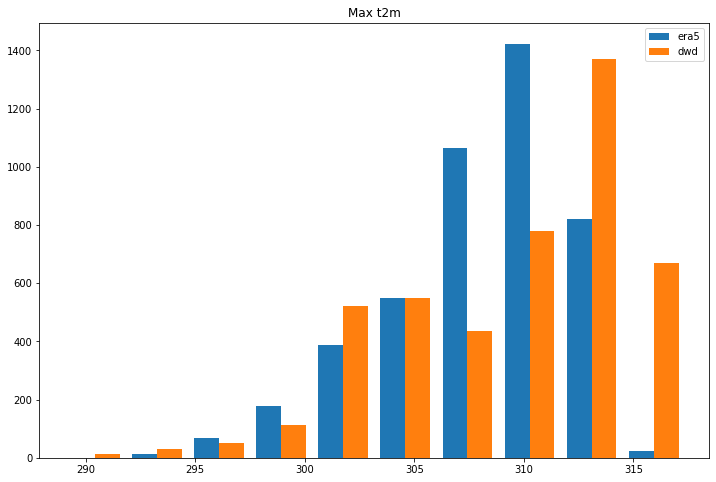

In [35]:
plt.figure(figsize=(12,8))
plt.title("Max t2m")
plt.hist([values_t2m_era5, values_t2m_dwd], label=['era5', 'dwd'])
plt.legend(loc='upper right')
plt.show()

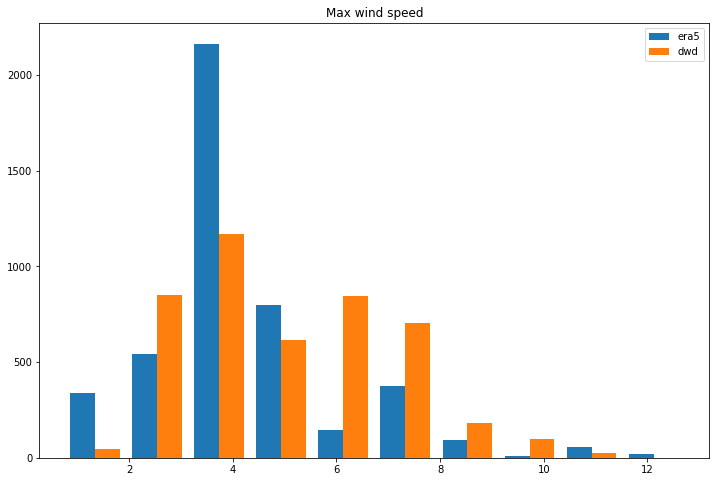

In [36]:
plt.figure(figsize=(12,8))
plt.title("Max wind speed")
plt.hist([values_wind_speed_era5, values_wind_speed_dwd], label=['era5', 'dwd'])
plt.legend(loc='upper right')
plt.show()

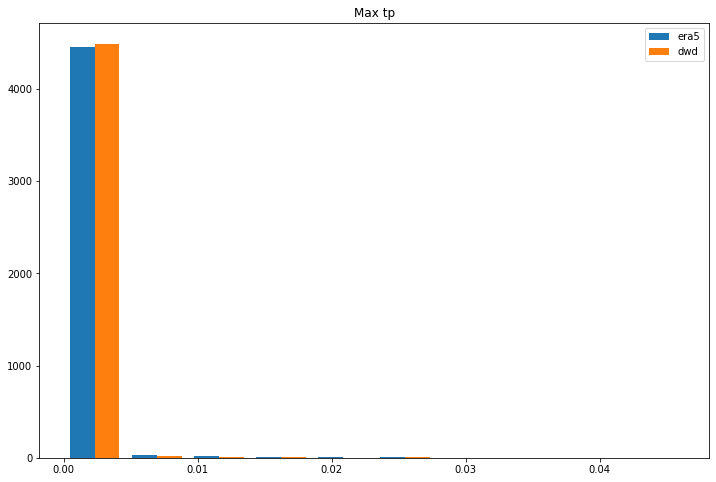

In [37]:
plt.figure(figsize=(12,8))
plt.title("Max tp")
plt.hist([values_tp_era5, values_tp_dwd], label=['era5', 'dwd'])
plt.legend(loc='upper right')
plt.show()

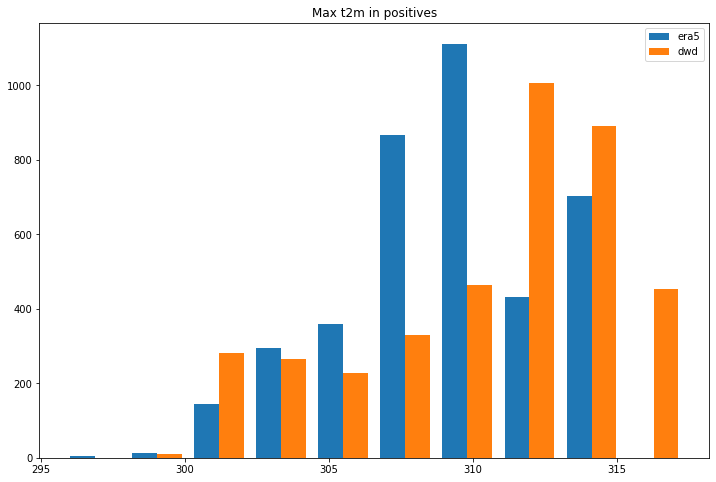

In [38]:
plt.figure(figsize=(12,8))
plt.title("Max t2m in positives")
plt.hist([values_t2m_positives_era5, values_t2m_positives_dwd], label=['era5', 'dwd'])
plt.legend(loc='upper right')
plt.show()

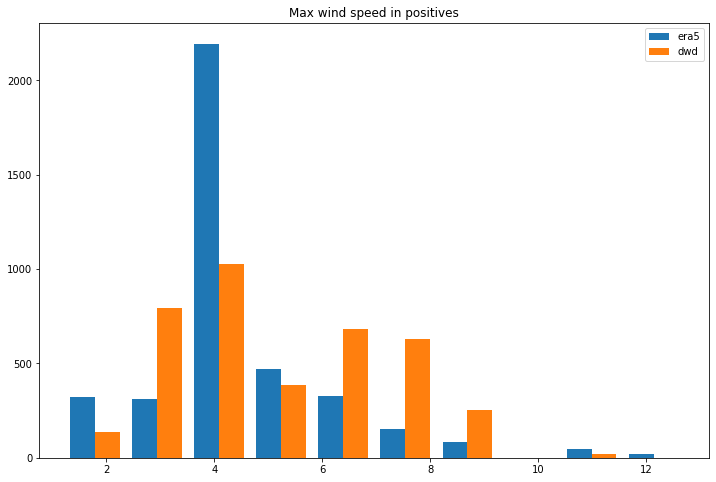

In [39]:
plt.figure(figsize=(12,8))
plt.title("Max wind speed in positives")
plt.hist([values_wind_speed_positives_era5, values_wind_speed_positives_dwd], label=['era5', 'dwd'])
plt.legend(loc='upper right')
plt.show()

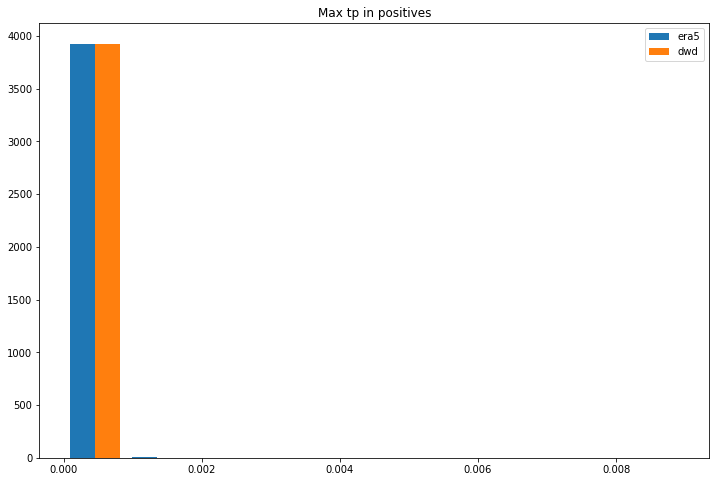

In [40]:
plt.figure(figsize=(12,8))
plt.title("Max tp in positives")
plt.hist([values_tp_positives_era5, values_tp_positives_dwd], label=['era5', 'dwd'])
plt.legend(loc='upper right')
plt.show()

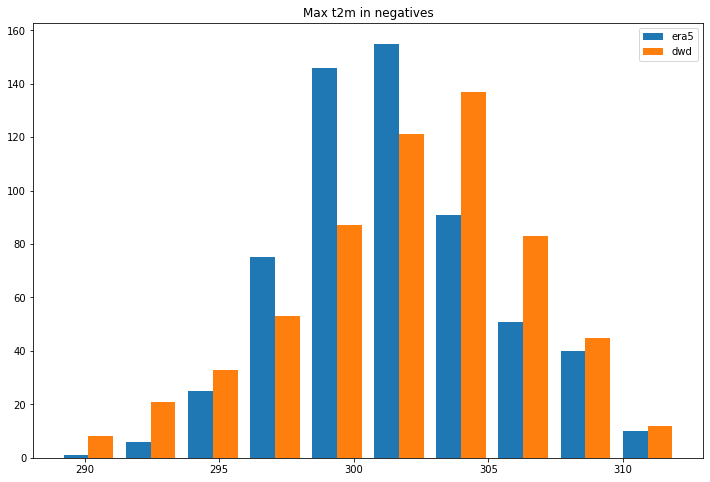

In [41]:
plt.figure(figsize=(12,8))
plt.title("Max t2m in negatives")
plt.hist([values_t2m_negatives_era5, values_t2m_negatives_dwd], label=['era5', 'dwd'])
plt.legend(loc='upper right')
plt.show()

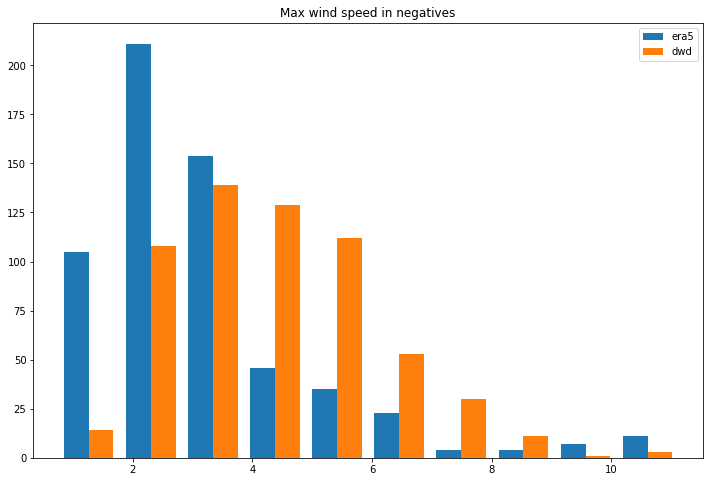

In [42]:
plt.figure(figsize=(12,8))
plt.title("Max wind speed in negatives")
plt.hist([values_wind_speed_negatives_era5, values_wind_speed_negatives_dwd], label=['era5', 'dwd'])
plt.legend(loc='upper right')
plt.show()

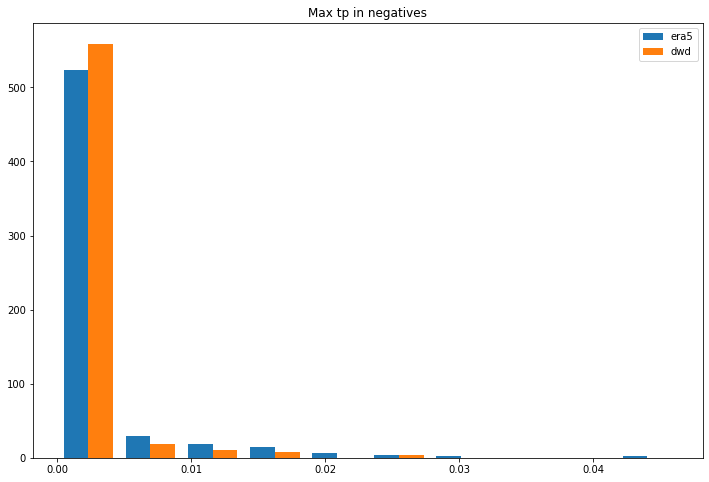

In [43]:
plt.figure(figsize=(12,8))
plt.title("Max tp in negatives")
plt.hist([values_tp_negatives_era5, values_tp_negatives_dwd], label=['era5', 'dwd'])
plt.legend(loc='upper right')
plt.show()

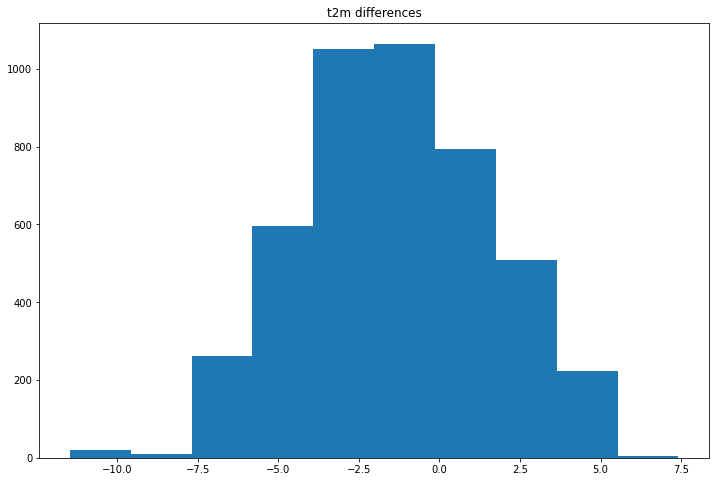

In [44]:
plt.figure(figsize=(12,8))
plt.title("t2m differences")
plt.hist(t2m_difference)
plt.show()

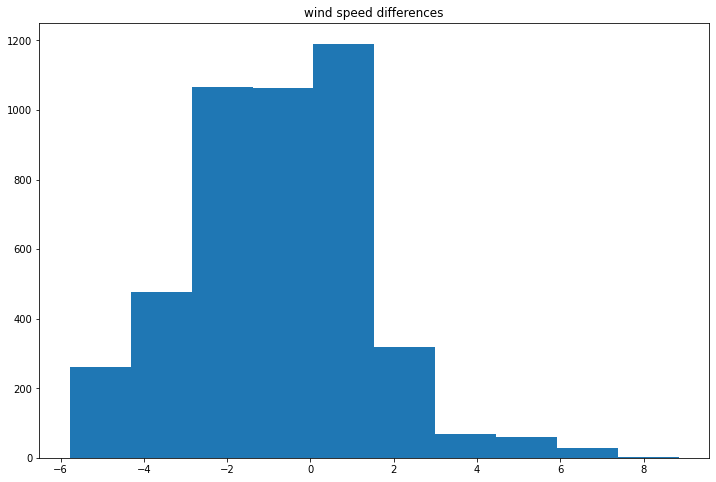

In [45]:
plt.figure(figsize=(12,8))
plt.title("wind speed differences")
plt.hist(wind_speed_difference)
plt.show()

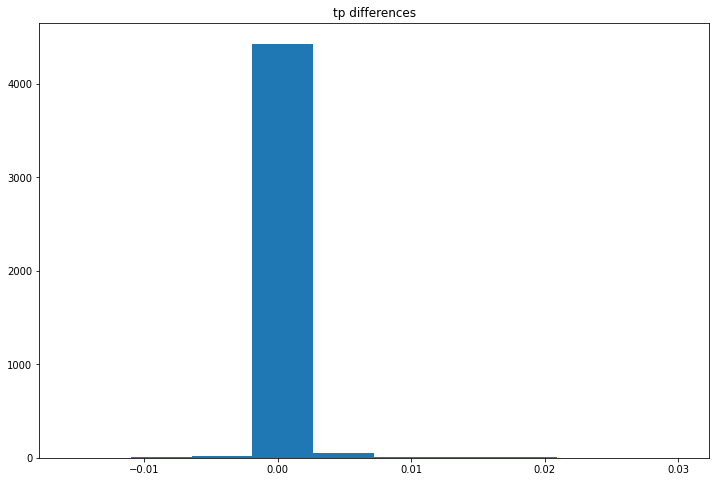

In [46]:
plt.figure(figsize=(12,8))
plt.title("tp differences")
plt.hist(tp_difference)
plt.show()

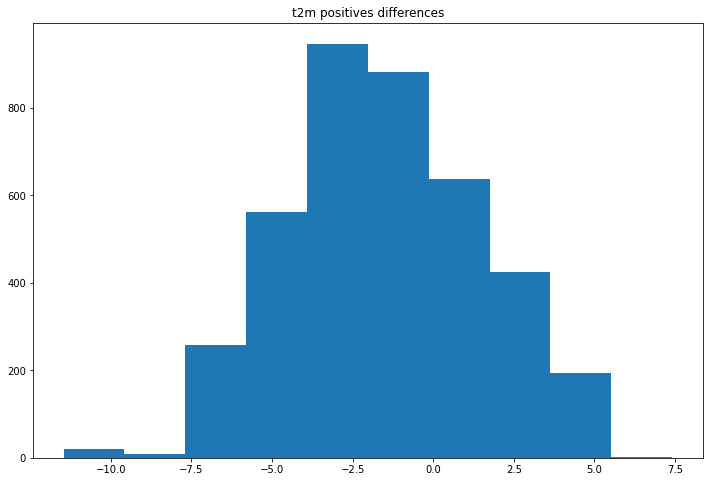

In [47]:
plt.figure(figsize=(12,8))
plt.title("t2m positives differences")
plt.hist(t2m_positives_difference)
plt.show()

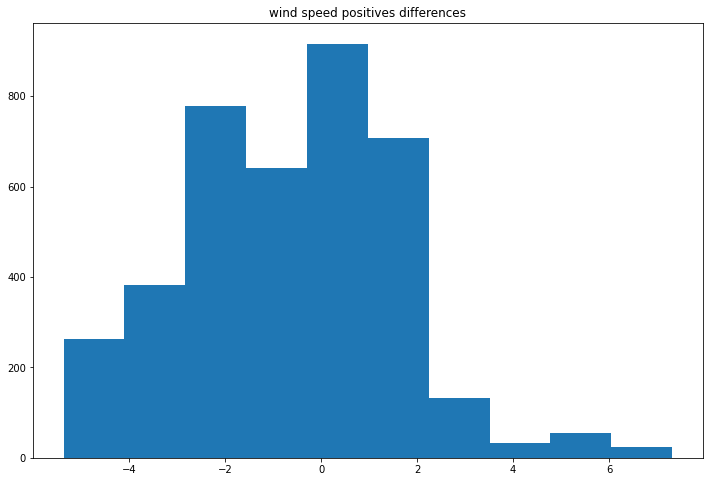

In [48]:
plt.figure(figsize=(12,8))
plt.title("wind speed positives differences")
plt.hist(wind_speed_positives_difference)
plt.show()

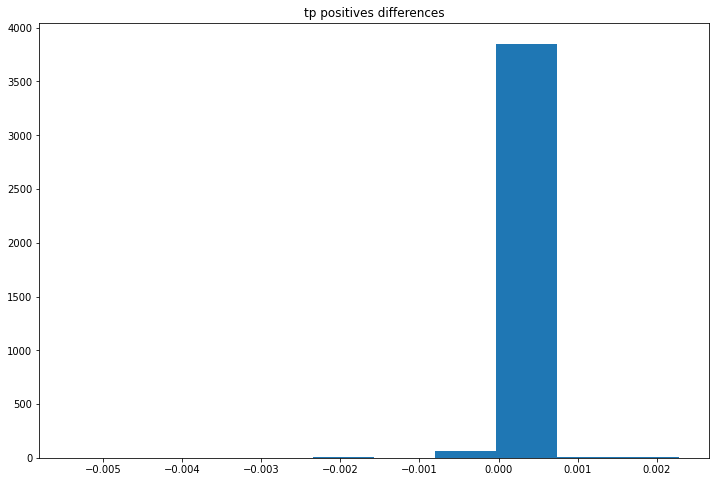

In [49]:
plt.figure(figsize=(12,8))
plt.title("tp positives differences")
plt.hist(tp_positives_difference)
plt.show()

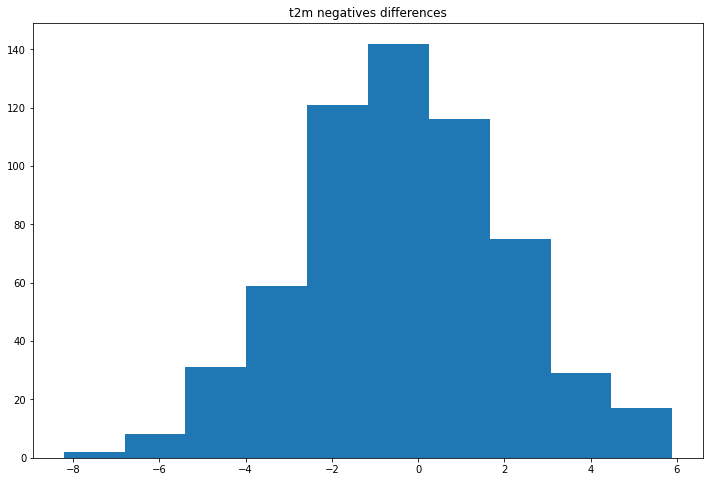

In [50]:
plt.figure(figsize=(12,8))
plt.title("t2m negatives differences")
plt.hist(t2m_negatives_difference)
plt.show()

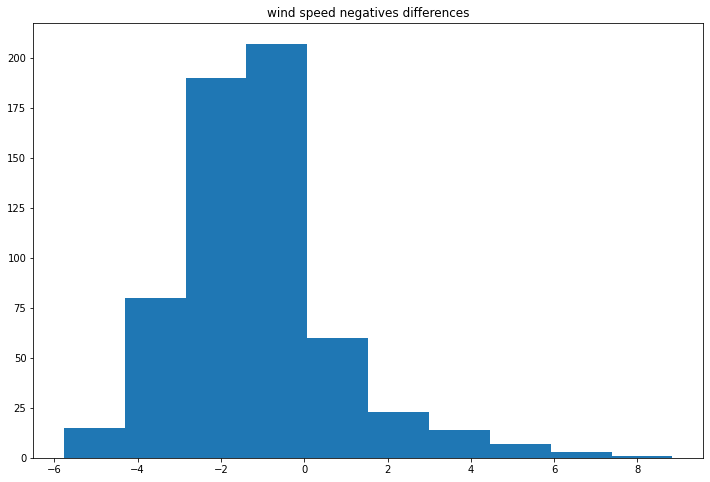

In [51]:
plt.figure(figsize=(12,8))
plt.title("wind speed negatives differences")
plt.hist(wind_speed_negatives_difference)
plt.show()

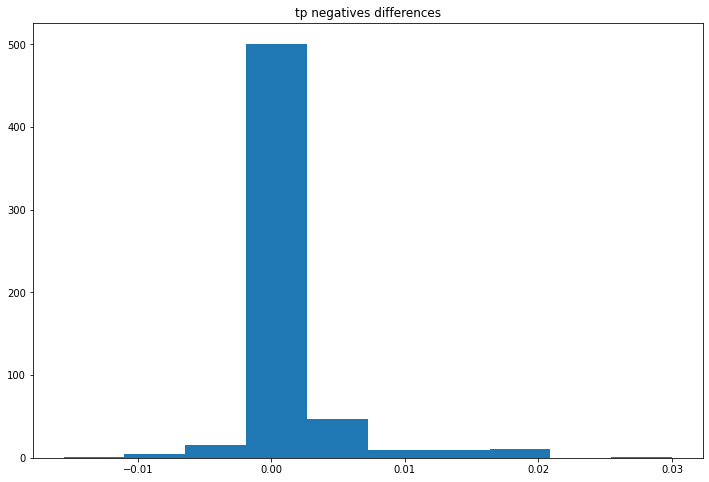

In [52]:
plt.figure(figsize=(12,8))
plt.title("tp negatives differences")
plt.hist(tp_negatives_difference)
plt.show()